In [1]:
import sys
sys.path.append("/data/yosef2/users/chenling/harmonization/MAGAN/MAGAN/")
sys.path.append("/data/yosef2/users/chenling/HarmonizationSCANVI")

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib
from utils import now
from model import MAGAN
from loader import Loader
import matplotlib.pyplot as plt
import matplotlib.cm

def correspondence_loss(b1, b2):
    """
    The correspondence loss.
    :param b1: a tensor representing the object in the graph of the current minibatch from domain one
    :param b2: a tensor representing the object in the graph of the current minibatch from domain two
    :returns a scalar tensor of the correspondence loss
    """
    domain1cols = [0]
    domain2cols = [0]
    loss = tf.constant(0.)
    for c1, c2 in zip(domain1cols, domain2cols):
        loss += tf.reduce_mean((b1[:, c1] - b2[:, c2])**2)

    return loss


In [3]:
import os
os.chdir("/data/yosef2/users/chenling/HarmonizationSCANVI")

In [4]:
import pickle as pkl
plotname = 'DentateGyrus'
from scvi.dataset.MouseBrain import DentateGyrus10X, DentateGyrusC1
from scvi.dataset.dataset import GeneExpressionDataset

dataset1= DentateGyrus10X()
dataset1.subsample_genes(dataset1.nb_genes)
dataset2 = DentateGyrusC1()
dataset2.subsample_genes(dataset2.nb_genes)
gene_dataset = GeneExpressionDataset.concat_datasets(dataset1,dataset2)

from scvi.dataset.dataset import SubsetGenes
dataset1, dataset2, gene_dataset = SubsetGenes(dataset1, dataset2, gene_dataset, plotname)

Downsampling from 14545 to 14545 genes
Downsampling from 5454 to 5454 cells
Downsampling from 16313 to 16302 genes
Downsampling from 2303 to 2303 cells
Keeping 13319 genes
Downsampling from 14545 to 1605 genes
Downsampling from 5454 to 5454 cells
Downsampling from 16302 to 1605 genes
Downsampling from 2303 to 2303 cells
Downsampling from 13319 to 1605 genes
Downsampling from 7757 to 7757 cells


In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
batch = gene_dataset.batch_indices.ravel()

In [7]:
X = gene_dataset.X

In [8]:
scaling_factor = gene_dataset.X.mean(axis=1)
norm_X = gene_dataset.X / scaling_factor.reshape(len(scaling_factor), 1)


In [9]:
index_0 = np.where(batch == 0)[0]
index_1 = np.where(batch == 1)[0]

X1 = np.log(1 + norm_X[index_0])
X2 = np.log(1 + norm_X[index_1])

In [10]:
norm_X.sum(axis=1)

array([1605., 1605., 1605., ..., 1605., 1605., 1605.], dtype=float32)

In [11]:
loadb1 = Loader(X1, shuffle=True)
loadb2 = Loader(X2, shuffle=True)
# Build the tf graph
magan = MAGAN(dim_b1=X1.shape[1], dim_b2=X2.shape[1], correspondence_loss=correspondence_loss)
# Train
loss=[]

In [12]:
for i in range(10000):
    xb1_ = loadb1.next_batch(100)
    xb2_ = loadb2.next_batch(100)
    magan.train(xb1_, xb2_)
    xb1_ = loadb1.next_batch(5454)
    xb2_ = loadb2.next_batch(2303)
    lstring = magan.get_loss(xb1_, xb2_)
    loss.append(lstring)

In [13]:
loss_D = [float(x.split(' ')[0]) for x in loss]

In [14]:
loss_G = [float(x.split(' ')[1]) for x in loss]

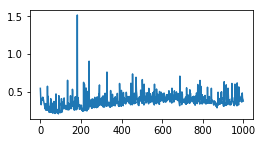

In [30]:
plt.figure(figsize=(4,2))
plt.plot(loss_D[:1000])
plt.savefig('Magan.loss_D.pdf')

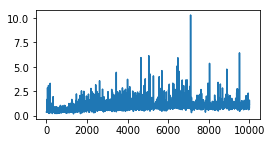

In [31]:
plt.figure(figsize=(4,2))
plt.plot(loss_G)
plt.savefig('Magan.loss_G.pdf')

In [17]:
loadb1 = Loader(X1, shuffle=False)
loadb2 = Loader(X2, shuffle=False)
xb1_ = loadb1.next_batch(len(index_0))
xb2_ = loadb2.next_batch(len(index_1))
lstring = magan.get_loss(xb1_, xb2_)
print("{} {}".format(magan.get_loss_names(), lstring))
xb1 = magan.get_layer(xb1_, xb2_, 'xb1')
xb2 = magan.get_layer(xb1_, xb2_, 'xb2')
Gb1 = magan.get_layer(xb1_, xb2_, 'Gb1')
Gb2 = magan.get_layer(xb1_, xb2_, 'Gb2')
arr1 = np.zeros_like(X, dtype=np.float)
arr1[index_0] = xb1
arr1[index_1] = Gb1
arr2 = np.zeros_like(X, dtype=np.float)
arr2[index_0] = Gb2
arr2[index_1] = xb2


Losses: D G 0.346 1.181


In [18]:
print(xb1.shape,xb2.shape,Gb1.shape,Gb2.shape)

(5454, 1605) (2303, 1605) (2303, 1605) (5454, 1605)


In [19]:
np.save('../%s/%s.magan.npy'%(plotname,'imputed0'),arr1)
np.save('../%s/%s.magan.npy'%(plotname,'imputed1'),arr2)

In [20]:
from sklearn.decomposition import PCA
latent = PCA(n_components=10).fit_transform(arr1)
np.save('../%s/%s.magan.npy'%(plotname,'latent0'),latent)

In [21]:
from sklearn.decomposition import PCA
latent = PCA(n_components=10).fit_transform(arr2)
np.save('../%s/%s.magan.npy'%(plotname,'latent1'),latent)

In [22]:
from umap import UMAP

In [34]:
latent = np.load('../%s/%s.magan.npy'%(plotname,'latent0'))
latent_u = UMAP(spread=2).fit_transform(latent)
labels = gene_dataset.labels.ravel()

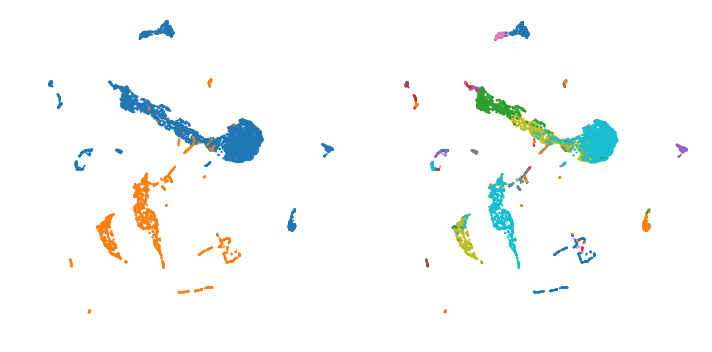

In [35]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
for i,x in enumerate([0,1]):
    idx = (batch==x)
    plt.scatter(latent_u[idx, 0], latent_u[idx, 1],label=x,edgecolors='none',s=5)
        
plt.axis("off")
# plt.legend()
plt.tight_layout()

plt.subplot(122)
for i,x in enumerate(np.unique(labels)):
    idx = (labels==x)
    plt.scatter(latent_u[idx, 0], latent_u[idx, 1],label=x,edgecolors='none',s=5)
        
plt.axis("off")
# plt.legend()
plt.tight_layout()

plt.savefig('Magan.latent0_u.pdf')

In [36]:
latent = np.load('../%s/%s.magan.npy'%(plotname,'latent1'))
latent_u = UMAP(spread=2).fit_transform(latent)
labels = gene_dataset.labels.ravel()

/data/yosef2/users/chenling/miniconda3/envs/pytorch_new/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


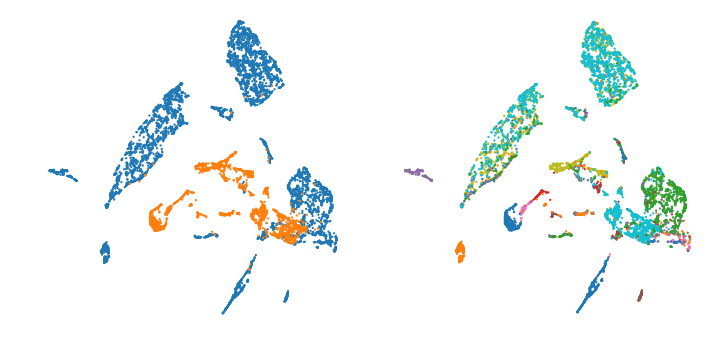

In [42]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
for i,x in enumerate([0,1]):
    idx = (batch==x)
    plt.scatter(latent_u[idx, 0], latent_u[idx, 1],label=x,edgecolors='none',s=5)
        
plt.axis("off")
plt.tight_layout()

plt.subplot(122)
for i,x in enumerate(np.unique(labels)):
    idx = (labels==x)
    plt.scatter(latent_u[idx, 0], latent_u[idx, 1],label=x,edgecolors='none',s=5)
        
plt.axis("off")
plt.tight_layout()

plt.savefig('Magan.latent1_u.pdf')

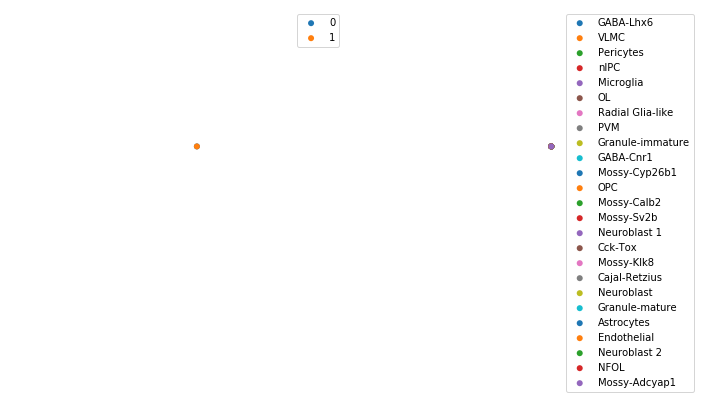

In [41]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
for i,x in enumerate([0,1]):
    idx = (batch==x)
    plt.scatter(latent_u[0, 0], latent_u[0, 1],label=x,edgecolors='none')
        
plt.axis("off")
plt.legend()
plt.tight_layout()

plt.subplot(122)
for i,x in enumerate(np.unique(labels)):
    idx = (labels==x)
    plt.scatter(latent_u[0, 0], latent_u[0, 1],
                label=gene_dataset.cell_types[i],edgecolors='none')
        
plt.axis("off")
plt.legend()
plt.tight_layout()

plt.savefig('Magan.legend.pdf')

In [27]:
from scvi.inference.posterior import entropy_batch_mixing
batch_entropy = entropy_batch_mixing(latent, batch)

In [28]:
batch_entropy

0.07049592205074466